# **04 - OpenQuake Ground Motion Field post-processing - ASC**

**IRDR0012 MSc Independent Research Project**

*   Candidate number: NWHL6
*   Institution: UCL IRDR
*   Supervisor: Dr. Roberto Gentile
*   Date: 01/09/2025
*   Version: v1.0

**Description:**

Analysis of 1000 realisations across multiple **Active Shallow Crust** (ASC) GMPEs and IMTs

**INPUT FILES:**

*   gmf-data_ASC_83.csv
*   sitemesh_ASC_83.csv

**OUTPUT FILES:**


*   gmf_complete_statistics.csv - Complete statistical results
*   gmf_statistics_AkkarEtAlRjb2014.csv - Akkar et al. results only
*   gmf_statistics_ChiouYoungs2014.csv - Chiou & Youngs results only
*   gmf_p50_pivot.csv - Median values in pivot format
*   gmf_std_pivot.csv - Standard deviation in pivot format
*   gmf_mean_pivot.csv - Mean values in pivot format

## 0 - ENVIRONMENT SETUP AND DEPENDENCIES

In [ ]:
# Install required packages for Google Colab
!pip install -q pandas numpy matplotlib seaborn plotly

# Import essential libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')

# Configure pandas display options
pd.set_option('display.max_columns', None)
pd.set_option('display.precision', 4)

print("✅ Environment setup complete")
print("📋 Libraries loaded: pandas, numpy, matplotlib, seaborn, plotly")

✅ Environment setup complete
📋 Libraries loaded: pandas, numpy, matplotlib, seaborn, plotly


## 1 - GOOGLE DRIVE INTEGRATION

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Define file paths (UPDATE THESE PATHS TO YOUR FILES)
GMF_FILE_PATH = '/content/drive/MyDrive/IRDR0012_Research Project/00 INPUT/gmf-data_ASC_83.csv'
SITEMESH_FILE_PATH = '/content/drive/MyDrive/IRDR0012_Research Project/00 INPUT/sitemesh_ASC_83.csv'

print("✅ Google Drive mounted successfully")
print("📁 File paths configured")
print(f"   GMF Data: {GMF_FILE_PATH}")
print(f"   Site Mesh: {SITEMESH_FILE_PATH}")

Mounted at /content/drive
✅ Google Drive mounted successfully
📁 File paths configured
   GMF Data: /content/drive/MyDrive/IRDR0012_Research Project/00 INPUT/gmf-data_ASC_83.csv
   Site Mesh: /content/drive/MyDrive/IRDR0012_Research Project/00 INPUT/sitemesh_ASC_83.csv


## 2 - DATA LOADING AND PREPROCESSING

In [ ]:
def load_openquake_data(gmf_path, sitemesh_path):
    """
    Load and preprocess OpenQuake GMF and sitemesh data

    Parameters:
    - gmf_path: Path to GMF data file
    - sitemesh_path: Path to sitemesh coordinate file

    Returns:
    - gmf_df: Processed GMF dataframe
    - sites_df: Site coordinates dataframe
    """

    print("🔄 Loading GMF data...")
    # Load GMF data (header on row 2, skip first row)
    gmf_df = pd.read_csv(gmf_path, skiprows=1)

    print("🔄 Loading site mesh data...")
    # Load site coordinates (header on row 2, skip first row)
    sites_df = pd.read_csv(sitemesh_path, skiprows=1)

    # Clean column names (remove any extra spaces)
    gmf_df.columns = gmf_df.columns.str.strip()
    sites_df.columns = sites_df.columns.str.strip()

    print(f"✅ GMF data loaded: {len(gmf_df):,} records")
    print(f"✅ Site mesh loaded: {len(sites_df):,} sites")

    return gmf_df, sites_df

# Load the data
gmf_data, site_coordinates = load_openquake_data(GMF_FILE_PATH, SITEMESH_FILE_PATH)

# Display data structure
print("\n📊 GMF Data Structure:")
print(f"   Shape: {gmf_data.shape}")
print(f"   Columns: {list(gmf_data.columns)}")

print("\n📊 Site Coordinates Structure:")
print(f"   Shape: {site_coordinates.shape}")
print(f"   Columns: {list(site_coordinates.columns)}")

🔄 Loading GMF data...
🔄 Loading site mesh data...
✅ GMF data loaded: 2,972,000 records
✅ Site mesh loaded: 1,773 sites

📊 GMF Data Structure:
   Shape: (2972000, 6)
   Columns: ['event_id', 'gmv_PGA', 'gmv_SA(0.3)', 'gmv_SA(0.6)', 'gmv_SA(1.0)', 'custom_site_id']

📊 Site Coordinates Structure:
   Shape: (1773, 3)
   Columns: ['custom_site_id', 'lon', 'lat']


## 3 - GMPE CLASSIFICATION AND DATA PREPARATION

In [ ]:
def classify_gmpe_and_prepare_data(gmf_df):
    """
    Classify realizations by GMPE based on event_id parity
    and prepare data for statistical analysis

    Parameters:
    - gmf_df: Raw GMF dataframe

    Returns:
    - processed_df: Dataframe with GMPE classification
    """

    print("🔄 Classifying GMPEs based on event_id...")

    # Create a copy for processing
    df = gmf_df.copy()

    # Classify GMPE based on event_id (even = AkkarEtAlRjb2014, odd = ChiouYoungs2014)
    df['gmpe'] = df['event_id'].apply(lambda x: 'AkkarEtAlRjb2014' if x % 2 == 0 else 'ChiouYoungs2014')

    # Define IMT columns
    imt_columns = ['gmv_PGA', 'gmv_SA(0.3)', 'gmv_SA(0.6)', 'gmv_SA(1.0)']

    # Verify all IMT columns exist
    missing_cols = [col for col in imt_columns if col not in df.columns]
    if missing_cols:
        print(f"⚠️  Warning: Missing columns: {missing_cols}")

    print(f"✅ GMPE classification complete")
    print(f"   Total realizations: {len(df):,}")
    print(f"   AkkarEtAlRjb2014: {len(df[df['gmpe'] == 'AkkarEtAlRjb2014']):,}")
    print(f"   ChiouYoungs2014: {len(df[df['gmpe'] == 'ChiouYoungs2014']):,}")
    print(f"   Unique sites: {df['custom_site_id'].nunique():,}")

    return df, imt_columns

# Process the data
processed_gmf, imt_cols = classify_gmpe_and_prepare_data(gmf_data)

# Display sample of processed data
print("\n📋 Sample of Processed Data:")
print(processed_gmf[['event_id', 'gmpe', 'custom_site_id'] + imt_cols].head())

🔄 Classifying GMPEs based on event_id...
✅ GMPE classification complete
   Total realizations: 2,972,000
   AkkarEtAlRjb2014: 1,486,000
   ChiouYoungs2014: 1,486,000
   Unique sites: 1,486

📋 Sample of Processed Data:
   event_id              gmpe custom_site_id  gmv_PGA  gmv_SA(0.3)  \
0         0  AkkarEtAlRjb2014       ev9byzg0   0.9860       1.0130   
1         0  AkkarEtAlRjb2014       evdbnrep   0.0415       0.0328   
2         0  AkkarEtAlRjb2014       evdbs50b   0.1395       0.0978   
3         0  AkkarEtAlRjb2014       evdbf9ed   0.1764       0.0933   
4         0  AkkarEtAlRjb2014       evd1tcf1   0.2219       0.4396   

   gmv_SA(0.6)  gmv_SA(1.0)  
0       0.5850       0.3760  
1       0.0461       0.0632  
2       0.0723       0.0773  
3       0.0837       0.0654  
4       0.3322       0.8876  


Starting data exploration...
🔍 EXPLORING DATA DISTRIBUTION
📊 Analyzing PGA distribution for 4 random sites:
   Sites selected: ['ev35zj8x', 'ev3vvd8c', 'evd1s7fx', 'evd3dq8n']
   GMPE: AkkarEtAlRjb2014


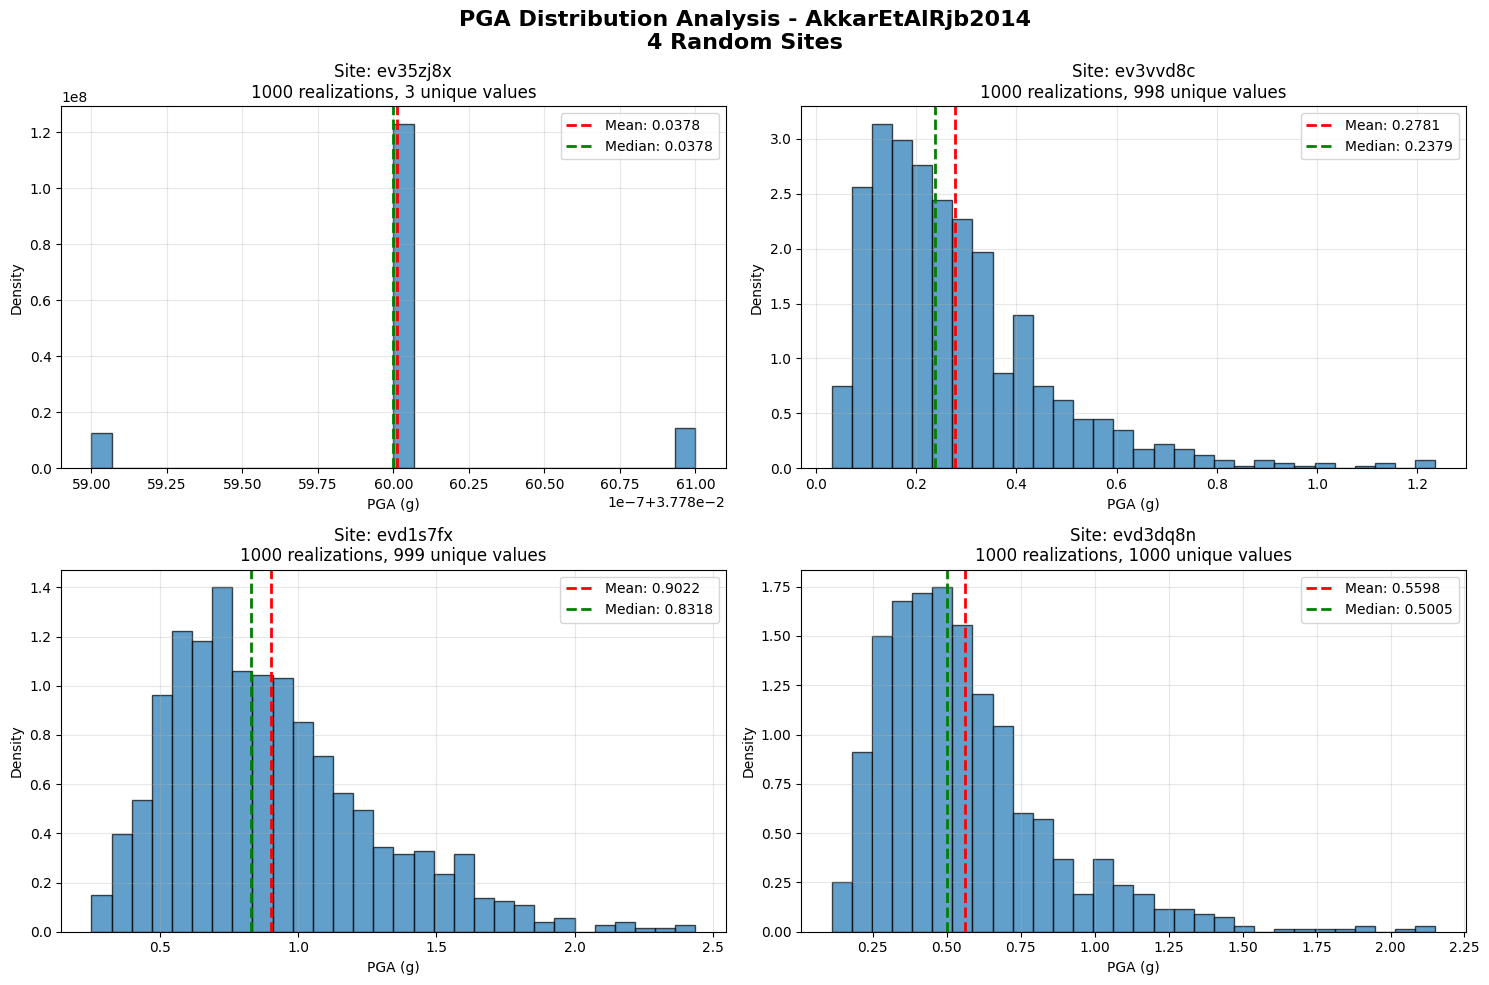


📈 STATISTICAL SUMMARY:
 site_id  count  unique_values   mean    std    min    max  range
ev35zj8x   1000              3 0.0378 0.0000 0.0378 0.0378 0.0000
ev3vvd8c   1000            998 0.2781 0.1796 0.0316 1.2358 1.2042
evd1s7fx   1000            999 0.9022 0.3703 0.2532 2.4368 2.1836
evd3dq8n   1000           1000 0.5598 0.2924 0.1101 2.1517 2.0417

🔍 DATA QUALITY ASSESSMENT:
   Total realizations (AkkarEtAlRjb2014): 1,486,000
   Sites with variability (>1 unique PGA): 1,439
   Sites with no variability (1 unique PGA): 47
   Average unique values per site: 851.7
   Max unique values per site: 1000

✅ Good variability detected - data suitable for statistical analysis


In [ ]:
def explore_data_distribution(df, imt_columns):
    """
    Explore data distribution for random sites to understand variability

    Parameters:
    - df: Processed GMF dataframe
    - imt_columns: List of IMT column names
    """

    print("🔍 EXPLORING DATA DISTRIBUTION")
    print("="*50)

    # Get AkkarEtAlRjb2014 data only for exploration
    akkar_data = df[df['gmpe'] == 'AkkarEtAlRjb2014'].copy()

    # Select 4 random sites
    np.random.seed(42)  # For reproducible results
    all_sites = akkar_data['custom_site_id'].unique()
    random_sites = np.random.choice(all_sites, size=min(4, len(all_sites)), replace=False)

    print(f"📊 Analyzing PGA distribution for {len(random_sites)} random sites:")
    print(f"   Sites selected: {list(random_sites)}")
    print(f"   GMPE: AkkarEtAlRjb2014")

    # Create subplots for histograms
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('PGA Distribution Analysis - AkkarEtAlRjb2014\n4 Random Sites', fontsize=16, fontweight='bold')

    # Statistical summary for each site
    site_stats = []

    for i, site_id in enumerate(random_sites):
        row, col = i // 2, i % 2
        ax = axes[row, col]

        # Get data for this site
        site_data = akkar_data[akkar_data['custom_site_id'] == site_id]['gmv_PGA']

        # Calculate basic statistics
        stats = {
            'site_id': site_id,
            'count': len(site_data),
            'unique_values': site_data.nunique(),
            'mean': site_data.mean(),
            'std': site_data.std(),
            'min': site_data.min(),
            'max': site_data.max(),
            'range': site_data.max() - site_data.min()
        }
        site_stats.append(stats)

        # Create histogram
        if site_data.nunique() > 1:
            ax.hist(site_data, bins=30, alpha=0.7, edgecolor='black', density=True)
            ax.axvline(site_data.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {site_data.mean():.4f}')
            ax.axvline(site_data.median(), color='green', linestyle='--', linewidth=2, label=f'Median: {site_data.median():.4f}')
        else:
            # If all values are the same, show a single bar
            ax.bar([site_data.iloc[0]], [1.0], width=0.001, alpha=0.7)
            ax.text(0.5, 0.5, f'Single Value:\n{site_data.iloc[0]:.4f}',
                   transform=ax.transAxes, ha='center', va='center',
                   bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.7))

        ax.set_title(f'Site: {site_id}\n{len(site_data)} realizations, {site_data.nunique()} unique values')
        ax.set_xlabel('PGA (g)')
        ax.set_ylabel('Density')
        ax.grid(True, alpha=0.3)
        ax.legend()

    plt.tight_layout()
    plt.show()

    # Display statistical summary table
    stats_df = pd.DataFrame(site_stats)
    print("\n📈 STATISTICAL SUMMARY:")
    print("="*80)
    print(stats_df.round(6).to_string(index=False))

    # Overall data assessment
    print(f"\n🔍 DATA QUALITY ASSESSMENT:")
    print("="*50)
    total_realizations = len(akkar_data)
    unique_combinations = akkar_data.groupby('custom_site_id')['gmv_PGA'].nunique()

    print(f"   Total realizations (AkkarEtAlRjb2014): {total_realizations:,}")
    print(f"   Sites with variability (>1 unique PGA): {(unique_combinations > 1).sum():,}")
    print(f"   Sites with no variability (1 unique PGA): {(unique_combinations == 1).sum():,}")
    print(f"   Average unique values per site: {unique_combinations.mean():.1f}")
    print(f"   Max unique values per site: {unique_combinations.max()}")

    if unique_combinations.max() == 1:
        print("\n⚠️  WARNING: All sites show NO VARIABILITY!")
        print("   This suggests the data might be deterministic rather than stochastic.")
        print("   Expected: ~1000 different PGA values per site")
        print("   Observed: 1 identical PGA value per site")
    elif unique_combinations.mean() < 10:
        print("\n⚠️  WARNING: Low variability detected!")
        print("   This might indicate data structure issues.")
    else:
        print("\n✅ Good variability detected - data suitable for statistical analysis")

    return stats_df, unique_combinations

# Perform data exploration
print("Starting data exploration...")
exploration_stats, site_variability = explore_data_distribution(processed_gmf, imt_cols)

In [ ]:
def calculate_epicenter_distances(df, site_coords, epicenter_lat=31.058, epicenter_lon=-8.385):
    """
    Calculate distances from sites to the epicenter using the Haversine formula

    Parameters:
    - df: Processed GMF dataframe
    - site_coords: Site coordinates dataframe
    - epicenter_lat: Latitude of epicenter
    - epicenter_lon: Longitude of epicenter

    Returns:
    - distances_df: DataFrame with site distances
    """

    from math import radians, cos, sin, asin, sqrt

    def haversine(lon1, lat1, lon2, lat2):
        """
        Calculate the great circle distance between two points
        on the earth (specified in decimal degrees)
        Returns distance in kilometers
        """
        # Convert decimal degrees to radians
        lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

        # Haversine formula
        dlon = lon2 - lon1
        dlat = lat2 - lat1
        a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
        c = 2 * asin(sqrt(a))
        r = 6371  # Radius of earth in kilometers
        return c * r

    print("\n📍 EPICENTER DISTANCE CALCULATION")
    print("="*50)
    print(f"Epicenter location: {epicenter_lat}°N, {epicenter_lon}°E")

    # Get the same 4 random sites used in exploration
    np.random.seed(42)  # Same seed as in explore_data_distribution
    akkar_data = df[df['gmpe'] == 'AkkarEtAlRjb2014']
    all_sites = akkar_data['custom_site_id'].unique()
    sample_sites = np.random.choice(all_sites, size=min(4, len(all_sites)), replace=False)

    # Calculate distances for sample sites
    distances = []
    for site_id in sample_sites:
        # Get site coordinates
        site_info = site_coords[site_coords['custom_site_id'] == site_id].iloc[0]
        site_lat = site_info['lat']
        site_lon = site_info['lon']

        # Calculate distance
        distance = haversine(epicenter_lon, epicenter_lat, site_lon, site_lat)

        distances.append({
            'site_id': site_id,
            'lat': site_lat,
            'lon': site_lon,
            'distance_km': distance
        })

    distances_df = pd.DataFrame(distances)
    distances_df = distances_df.sort_values('distance_km')

    print("\nSite distances from epicenter:")
    print(distances_df[['site_id', 'distance_km']].round(2).to_string(index=False))

    return distances_df

# Add this function call after explore_data_distribution in Section 3
site_distances = calculate_epicenter_distances(processed_gmf, site_coordinates)


📍 EPICENTER DISTANCE CALCULATION
Epicenter location: 31.058°N, -8.385°E

Site distances from epicenter:
 site_id  distance_km
evd1s7fx        22.56
evd3dq8n        42.84
ev3vvd8c        57.90
ev35zj8x       144.05


## 4 - STATISTICAL CALCULATIONS

In [ ]:
def calculate_comprehensive_statistics(df, imt_columns, percentiles=[0.05, 0.16, 0.5, 0.84, 0.95]):
    """
    Calculate comprehensive statistics for each GMPE-IMT combination

    Parameters:
    - df: Processed GMF dataframe
    - imt_columns: List of IMT column names
    - percentiles: List of percentiles to calculate

    Returns:
    - stats_results: Dictionary of statistical results
    """

    print("🔄 Calculating comprehensive statistics...")
    print(f"   Percentiles: {[f'{p*100:.0f}%' for p in percentiles]}")

    stats_results = {}

    # Calculate statistics for each GMPE
    for gmpe in df['gmpe'].unique():
        print(f"\n   Processing {gmpe}...")
        gmpe_data = df[df['gmpe'] == gmpe]
        gmpe_stats = {}

        for imt in imt_columns:
            print(f"     → {imt}")

            # Group by site and calculate statistics
            site_stats = gmpe_data.groupby('custom_site_id')[imt].agg([
                'mean',
                'std',
                'count',
                lambda x: np.percentile(x, percentiles[0] * 100),  # 5th percentile
                lambda x: np.percentile(x, percentiles[1] * 100),  # 16th percentile
                lambda x: np.percentile(x, percentiles[2] * 100),  # 50th percentile (median)
                lambda x: np.percentile(x, percentiles[3] * 100),  # 84th percentile
                lambda x: np.percentile(x, percentiles[4] * 100),  # 95th percentile
            ]).round(6)

            # Rename columns for clarity
            site_stats.columns = [
                'mean', 'std', 'count',
                f'p{percentiles[0]*100:.0f}',
                f'p{percentiles[1]*100:.0f}',
                f'p{percentiles[2]*100:.0f}',
                f'p{percentiles[3]*100:.0f}',
                f'p{percentiles[4]*100:.0f}'
            ]

            # Add IMT and GMPE identifiers
            site_stats['imt'] = imt.replace('gmv_', '')
            site_stats['gmpe'] = gmpe
            site_stats = site_stats.reset_index()

            gmpe_stats[imt] = site_stats

        stats_results[gmpe] = gmpe_stats

    print("✅ Statistical calculations complete")
    return stats_results

# Calculate statistics
statistical_results = calculate_comprehensive_statistics(processed_gmf, imt_cols)

# Display sample results
print("\n📊 Sample Statistical Results:")
sample_gmpe = list(statistical_results.keys())[0]
sample_imt = list(statistical_results[sample_gmpe].keys())[0]
print(f"\n{sample_gmpe} - {sample_imt}:")
print(statistical_results[sample_gmpe][sample_imt].head())


🔄 Calculating comprehensive statistics...
   Percentiles: ['5%', '16%', '50%', '84%', '95%']

   Processing AkkarEtAlRjb2014...
     → gmv_PGA
     → gmv_SA(0.3)
     → gmv_SA(0.6)
     → gmv_SA(1.0)

   Processing ChiouYoungs2014...
     → gmv_PGA
     → gmv_SA(0.3)
     → gmv_SA(0.6)
     → gmv_SA(1.0)
✅ Statistical calculations complete

📊 Sample Statistical Results:

AkkarEtAlRjb2014 - gmv_PGA:
  custom_site_id    mean  std  count      p5     p16     p50     p84     p95  \
0       ev31wbdb  0.0624  0.0   1000  0.0624  0.0624  0.0624  0.0624  0.0624   
1       ev33dr5t  0.0638  0.0   1000  0.0638  0.0638  0.0638  0.0638  0.0638   
2       ev35xvx1  0.0852  0.0   1000  0.0852  0.0852  0.0852  0.0852  0.0852   
3       ev35zj8x  0.0378  0.0   1000  0.0378  0.0378  0.0378  0.0378  0.0378   
4       ev37w0ez  0.2252  0.0   1000  0.2252  0.2252  0.2252  0.2252  0.2252   

   imt              gmpe  
0  PGA  AkkarEtAlRjb2014  
1  PGA  AkkarEtAlRjb2014  
2  PGA  AkkarEtAlRjb2014  
3  PGA  A

## 5 - RESULTS CONSOLIDATION AND COORDINATE INTEGRATION

In [ ]:
def consolidate_results_with_coordinates(stats_results, site_coords):
    """
    Consolidate all statistical results and integrate with site coordinates

    Parameters:
    - stats_results: Dictionary of statistical results
    - site_coords: Site coordinates dataframe

    Returns:
    - final_results: Comprehensive results dataframe
    """

    print("🔄 Consolidating results and integrating coordinates...")

    # Combine all results into a single dataframe
    all_results = []

    for gmpe, gmpe_data in stats_results.items():
        for imt, imt_data in gmpe_data.items():
            all_results.append(imt_data)

    # Concatenate all results
    combined_results = pd.concat(all_results, ignore_index=True)

    # Merge with site coordinates
    final_results = combined_results.merge(
        site_coordinates,
        on='custom_site_id',
        how='left'
    )

    # Reorder columns for better readability
    coord_cols = ['custom_site_id', 'lon', 'lat'] if 'lon' in final_results.columns else ['custom_site_id']
    other_cols = [col for col in final_results.columns if col not in coord_cols]
    final_results = final_results[coord_cols + other_cols]

    print(f"✅ Results consolidated: {len(final_results):,} records")
    print(f"   GMPEs: {final_results['gmpe'].nunique()}")
    print(f"   IMTs: {final_results['imt'].nunique()}")
    print(f"   Sites: {final_results['custom_site_id'].nunique()}")

    return final_results

# Consolidate results
final_statistical_results = consolidate_results_with_coordinates(statistical_results, site_coordinates)

print("\n📋 Final Results Structure:")
print(f"   Shape: {final_statistical_results.shape}")
print(f"   Columns: {list(final_statistical_results.columns)}")

🔄 Consolidating results and integrating coordinates...
✅ Results consolidated: 11,888 records
   GMPEs: 2
   IMTs: 4
   Sites: 1486

📋 Final Results Structure:
   Shape: (11888, 13)
   Columns: ['custom_site_id', 'lon', 'lat', 'mean', 'std', 'count', 'p5', 'p16', 'p50', 'p84', 'p95', 'imt', 'gmpe']


## 6 - EXPORT RESULTS TO GOOGLE DRIVE

In [ ]:
def export_results(results_df, output_path='/content/drive/MyDrive/IRDR0012_Research Project/01 OUTPUT/'):
    """
    Export results to multiple formats for different use cases

    Parameters:
    - results_df: Final results dataframe
    - output_path: Base output directory path
    """

    print("🔄 Exporting results...")

    # Create output directory if it doesn't exist
    import os
    os.makedirs(output_path, exist_ok=True)

    # Export complete results
    complete_file = f"{output_path}gmf_complete_statistics.csv"
    results_df.to_csv(complete_file, index=False)
    print(f"✅ Complete results exported: {complete_file}")

    # Export separate files for each GMPE
    for gmpe in results_df['gmpe'].unique():
        gmpe_data = results_df[results_df['gmpe'] == gmpe]
        gmpe_file = f"{output_path}gmf_statistics_{gmpe}.csv"
        gmpe_data.to_csv(gmpe_file, index=False)
        print(f"✅ {gmpe} results exported: {gmpe_file}")

    # Export pivot tables for easy analysis
    for stat in ['p50', 'std', 'mean']:  # median, std dev, mean
        pivot = results_df.pivot_table(
            values=stat,
            index=['custom_site_id', 'lon', 'lat'],
            columns=['gmpe', 'imt']
        ).round(6)
        pivot_file = f"{output_path}gmf_{stat}_pivot.csv"
        pivot.to_csv(pivot_file)
        print(f"✅ {stat.upper()} pivot table exported: {pivot_file}")

    print("✅ All exports complete")

# Export results
export_results(final_statistical_results)


🔄 Exporting results...
✅ Complete results exported: /content/drive/MyDrive/IRDR0012_Research Project/01 OUTPUT/gmf_complete_statistics.csv
✅ AkkarEtAlRjb2014 results exported: /content/drive/MyDrive/IRDR0012_Research Project/01 OUTPUT/gmf_statistics_AkkarEtAlRjb2014.csv
✅ ChiouYoungs2014 results exported: /content/drive/MyDrive/IRDR0012_Research Project/01 OUTPUT/gmf_statistics_ChiouYoungs2014.csv
✅ P50 pivot table exported: /content/drive/MyDrive/IRDR0012_Research Project/01 OUTPUT/gmf_p50_pivot.csv
✅ STD pivot table exported: /content/drive/MyDrive/IRDR0012_Research Project/01 OUTPUT/gmf_std_pivot.csv
✅ MEAN pivot table exported: /content/drive/MyDrive/IRDR0012_Research Project/01 OUTPUT/gmf_mean_pivot.csv
✅ All exports complete


## 7 - SUMMARY STATISTICS AND QUALITY CHECKS

In [ ]:
def generate_summary_report(results_df):
    """
    Generate comprehensive summary report of the analysis

    Parameters:
    - results_df: Final results dataframe
    """

    print("=" * 60)
    print("📊 OPENQUAKE GMF ANALYSIS SUMMARY REPORT")
    print("=" * 60)

    # Basic statistics
    print(f"\n🔢 DATA OVERVIEW:")
    print(f"   Total sites analyzed: {results_df['custom_site_id'].nunique():,}")
    print(f"   GMPEs analyzed: {', '.join(results_df['gmpe'].unique())}")
    print(f"   IMTs analyzed: {', '.join(results_df['imt'].unique())}")
    print(f"   Realizations per combination: {results_df['count'].iloc[0]:,}")

    # Statistical ranges
    print(f"\n📈 STATISTICAL RANGES:")
    for imt in results_df['imt'].unique():
        imt_data = results_df[results_df['imt'] == imt]
        print(f"\n   {imt}:")
        print(f"     Median range: {imt_data['p50'].min():.4f} - {imt_data['p50'].max():.4f}")
        print(f"     Mean std dev: {imt_data['std'].mean():.4f}")
        print(f"     95% range: {imt_data['p5'].min():.4f} - {imt_data['p95'].max():.4f}")

    # GMPE comparison
    print(f"\n⚖️  GMPE COMPARISON (Median Values):")
    for imt in results_df['imt'].unique():
        print(f"\n   {imt}:")
        gmpe_comparison = results_df[results_df['imt'] == imt].groupby('gmpe')['p50'].agg(['mean', 'std'])
        for gmpe in gmpe_comparison.index:
            mean_val = gmpe_comparison.loc[gmpe, 'mean']
            std_val = gmpe_comparison.loc[gmpe, 'std']
            print(f"     {gmpe}: {mean_val:.4f} ± {std_val:.4f}")

    print(f"\n✅ Analysis complete - Results ready for damage matrix calculations")
    print("=" * 60)

# Generate summary report
generate_summary_report(final_statistical_results)

📊 OPENQUAKE GMF ANALYSIS SUMMARY REPORT

🔢 DATA OVERVIEW:
   Total sites analyzed: 1,486
   GMPEs analyzed: AkkarEtAlRjb2014, ChiouYoungs2014
   IMTs analyzed: PGA, SA(0.3), SA(0.6), SA(1.0)
   Realizations per combination: 1,000

📈 STATISTICAL RANGES:

   PGA:
     Median range: 0.0242 - 1.6453
     Mean std dev: 0.3010
     95% range: 0.0242 - 4.7999

   SA(0.3):
     Median range: 0.0127 - 1.2585
     Mean std dev: 0.2330
     95% range: 0.0127 - 3.7266

   SA(0.6):
     Median range: 0.0171 - 1.0682
     Mean std dev: 0.2505
     95% range: 0.0081 - 3.2535

   SA(1.0):
     Median range: 0.0185 - 0.8749
     Mean std dev: 0.2379
     95% range: 0.0074 - 2.4120

⚖️  GMPE COMPARISON (Median Values):

   PGA:
     AkkarEtAlRjb2014: 0.6268 ± 0.3474
     ChiouYoungs2014: 0.4584 ± 0.2089

   SA(0.3):
     AkkarEtAlRjb2014: 0.5171 ± 0.2799
     ChiouYoungs2014: 0.3844 ± 0.1614

   SA(0.6):
     AkkarEtAlRjb2014: 0.4276 ± 0.2350
     ChiouYoungs2014: 0.3379 ± 0.1416

   SA(1.0):
     Akkar

## 8 - VISUALISATION

🎨 Creating summary visualizations...


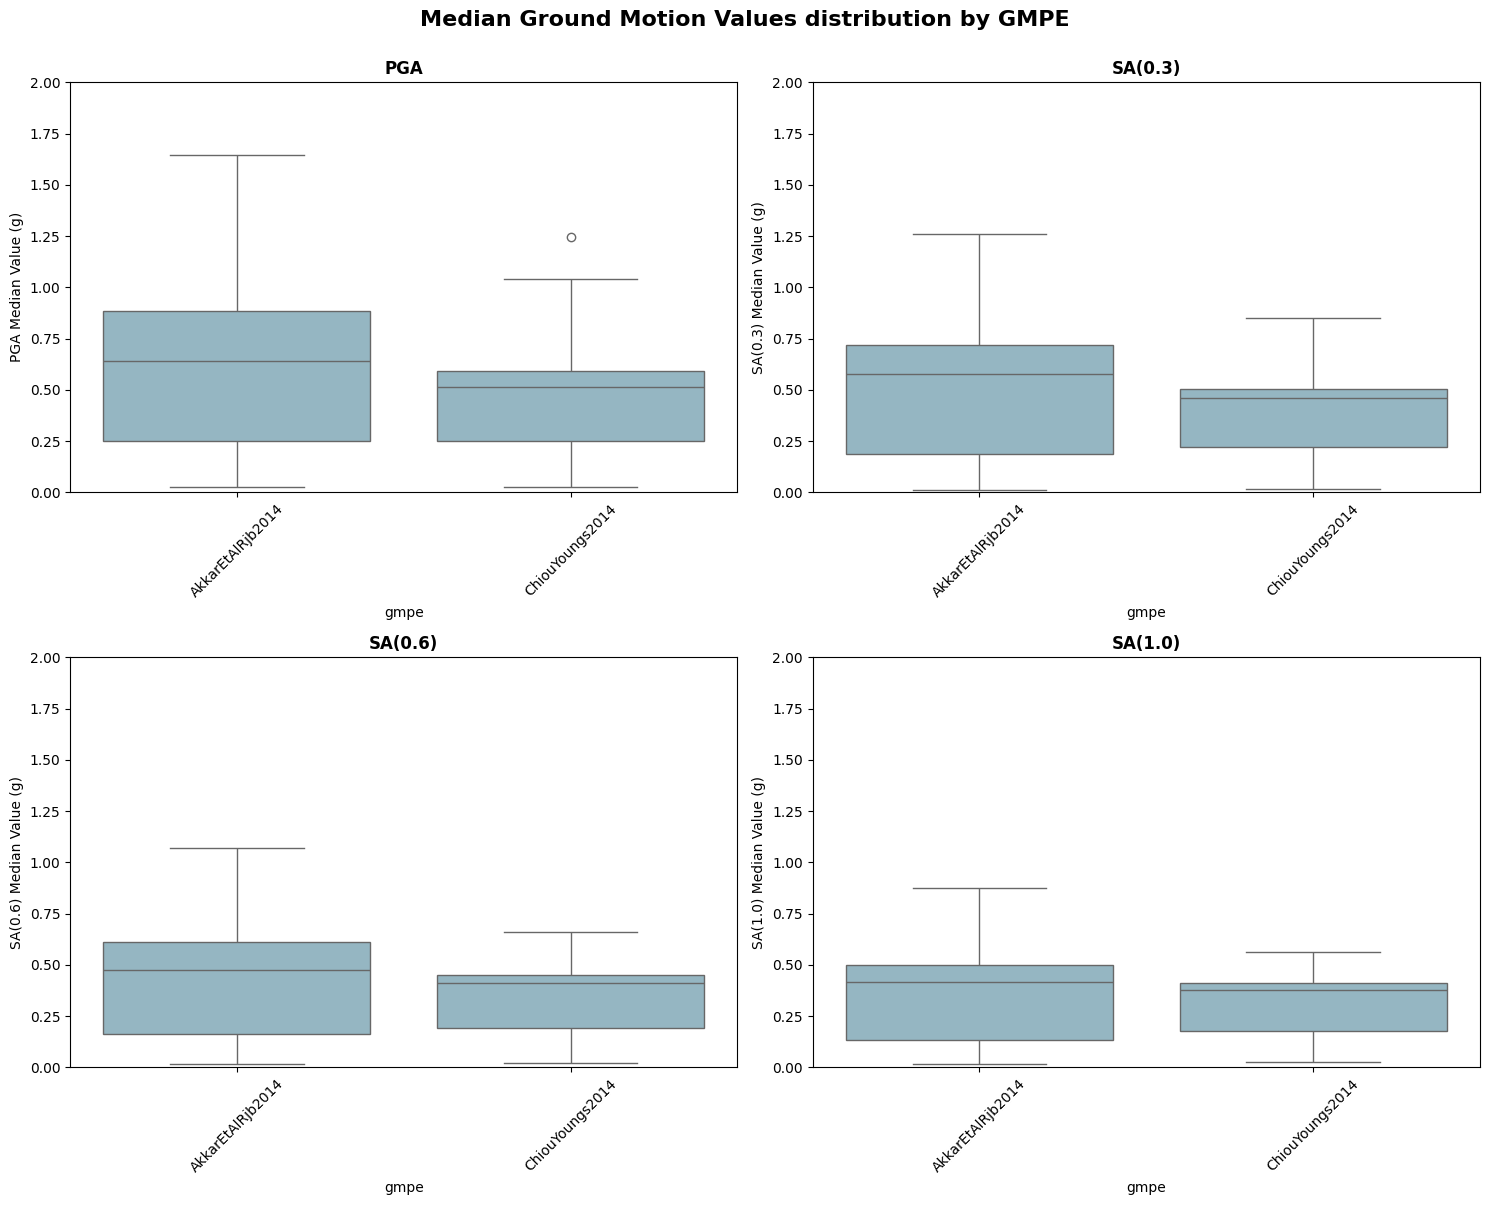

✅ Visualizations complete


In [ ]:
def create_summary_visualizations(results_df):
    """
    Create summary visualizations of the statistical results

    Parameters:
    - results_df: Final results dataframe
    """

    print("🎨 Creating summary visualizations...")

    # Report style colors
    color_main = "#8DB9CA"
    color_second = "#FCD16D"
    color_edge = "#3B3838"
    infill = "#EFEFEF"
    sns.set(font='Arial')

    # Set up the plotting style
    plt.style.use('default')
    sns.set_palette("husl")

    # Create subplots for median values comparison
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('Median Ground Motion Values distribution by GMPE', fontsize=16, fontweight='bold', y=1.0)

    imts = results_df['imt'].unique()
    for i, imt in enumerate(imts):
        row, col = i // 2, i % 2
        ax = axes[row, col]

        imt_data = results_df[results_df['imt'] == imt]

        # Box plot comparing GMPEs
        sns.boxplot(data=imt_data, x='gmpe', y='p50', ax=ax, color=color_main)
        ax.set_title(imt, fontweight='bold')
        ax.set_ylabel(f'{imt} Median Value (g)')
        ax.set_ylim(0,2)
        ax.tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

    print("✅ Visualizations complete")

# Create visualizations
create_summary_visualizations(final_statistical_results)

## 9 - FINAL OUTPUT SUMMARY

In [ ]:
print("\n" + "="*60)
print("🎯 ANALYSIS COMPLETE - READY FOR DAMAGE MATRIX")
print("="*60)

print(f"""
📁 OUTPUT FILES GENERATED:
   • gmf_complete_statistics.csv - Complete statistical results
   • gmf_statistics_AkkarEtAlRjb2014.csv - Akkar et al. results only
   • gmf_statistics_ChiouYoungs2014.csv - Chiou & Youngs results only
   • gmf_p50_pivot.csv - Median values in pivot format
   • gmf_std_pivot.csv - Standard deviation in pivot format
   • gmf_mean_pivot.csv - Mean values in pivot format

📊 DATA READY FOR:
   ✅ Damage matrix calculations
   ✅ Fragility curve applications
   ✅ Risk assessment modeling
   ✅ GIS integration (QGIS compatible)

🔢 STATISTICAL MEASURES AVAILABLE:
   • Median (50th percentile) - Primary measure for damage calculations
   • Standard deviation - Uncertainty quantification
   • Mean values - Alternative central tendency
   • 5th, 16th, 84th, 95th percentiles - Confidence intervals
   • Site coordinates - Spatial analysis ready
""")

print("="*60)


🎯 ANALYSIS COMPLETE - READY FOR DAMAGE MATRIX

📁 OUTPUT FILES GENERATED:
   • gmf_complete_statistics.csv - Complete statistical results
   • gmf_statistics_AkkarEtAlRjb2014.csv - Akkar et al. results only
   • gmf_statistics_ChiouYoungs2014.csv - Chiou & Youngs results only
   • gmf_p50_pivot.csv - Median values in pivot format
   • gmf_std_pivot.csv - Standard deviation in pivot format
   • gmf_mean_pivot.csv - Mean values in pivot format

📊 DATA READY FOR:
   ✅ Damage matrix calculations
   ✅ Fragility curve applications
   ✅ Risk assessment modeling
   ✅ GIS integration (QGIS compatible)

🔢 STATISTICAL MEASURES AVAILABLE:
   • Median (50th percentile) - Primary measure for damage calculations
   • Standard deviation - Uncertainty quantification
   • Mean values - Alternative central tendency
   • 5th, 16th, 84th, 95th percentiles - Confidence intervals
   • Site coordinates - Spatial analysis ready

